# 📊 Modelagem Epidemiológica da COVID-19 no Pará com o Modelo SIRC

Neste notebook é apresentada a aplicação de um **modelo epidemiológico compartimental do tipo SIRC** — *Suscetíveis (S)*, *Infectados (I)*, *Recuperados (R)* e *Casos acumulados (C)* — para descrever e ajustar a dinâmica da pandemia de **COVID-19 no estado do Pará**, com base em dados reais de casos confirmados.

O objetivo central é **ajustar um sistema de equações diferenciais ordinárias (EDOs)** aos dados observados de casos acumulados, estimando parâmetros epidemiológicos relevantes por meio de **otimização não linear**.

---

## 🔬 Visão Geral da Metodologia

O fluxo de trabalho adotado neste estudo pode ser dividido em quatro etapas principais:

### 1️⃣ Leitura e organização dos dados epidemiológicos

Os dados são carregados a partir de um arquivo no formato `parquet`, contendo registros diários de casos confirmados de COVID-19. Neste estudo os dados selecionados são para Belém-Pa. A variável observada principal é o número de **casos novos diários**, a partir do qual se constrói a série de **casos acumulados**.

---

### 2️⃣ Construção das séries temporais

Seja \( C(t) \) o número acumulado de casos no tempo \( t \). A partir da série de casos novos \( \Delta C(t) \), calcula-se:

$$\[
C(t) = \sum_{i=1}^{t} \Delta C(i)
\]$$

A análise é restrita aos **primeiros 150 dias da pandemia**, período no qual a dinâmica de crescimento é mais informativa para a estimação dos parâmetros epidemiológicos.

---

### 3️⃣ Modelo Epidemiológico SIRC

O modelo SIRC descreve a evolução temporal das populações por meio do seguinte sistema de equações diferenciais ordinárias:


\begin{aligned}
\frac{dS}{dt} &= -\beta \frac{S I}{N} \\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I \\
\frac{dC}{dt} &= \beta \frac{S I}{N}
\end{aligned}


onde:

- \( S(t) \): número de indivíduos suscetíveis
- \( I(t) \): número de indivíduos infectados
- \( R(t) \): número de indivíduos recuperados
- \( C(t) \): número de casos acumulados
- \( \beta \): taxa de contágio
- \( \gamma \): taxa de recuperação
- \( N \): população total considerada (constante)

A condição inicial do sistema é dada por:


\begin{aligned}
S(0) &= N - I_0 \\
I(0) &= I_0 \\
R(0) &= 0 \\
C(0) &= I_0
\end{aligned}


---

### 4️⃣ Resolução Numérica e Ajuste do Modelo

O sistema de EDOs é resolvido numericamente por meio do método de **integração de Runge–Kutta**, implementado pela função `odeint` da biblioteca `scipy`.

O ajuste do modelo aos dados observados é realizado utilizando a biblioteca **`lmfit`**, que permite:

- Definir parâmetros livres e fixos;
- Impor limites físicos aos parâmetros;
- Estimar incertezas associadas aos parâmetros;
- Avaliar correlações entre eles.

O processo de ajuste minimiza a função objetivo:

$
\min_{\beta, \gamma} \sum_{t} \left[ C_{\text{obs}}(t) - C_{\text{mod}}(t; \beta, \gamma) \right]^2
$

---

## 📈 Métricas de Avaliação

A qualidade do ajuste é avaliada a partir de métricas estatísticas como:

- coeficiente de determinação \( R^2 \);
- qui-quadrado reduzido \( \chi^2_{\text{red}} \);
- Critério de Informação de Akaike (AIC);
- Critério de Informação Bayesiano (BIC).

Essas métricas permitem avaliar tanto a aderência do modelo aos dados quanto a complexidade do ajuste.

---

## 🎯 Importância do Estudo

A modelagem epidemiológica baseada em modelos compartimentais permite:

- compreender a dinâmica temporal da pandemia em escala regional;
- estimar parâmetros epidemiológicos relevantes;
- comparar diferentes regiões e períodos;
- avaliar a adequação de modelos mecanísticos a dados reais;
- fornecer subsídios quantitativos para análises retrospectivas e estudos em saúde pública.

Este notebook tem caráter **exploratório e quantitativo**, servindo como base para extensões futuras, como a inclusão de efeitos temporais, intervenções não farmacológicas ou variação de parâmetros no tempo.


## 🧩 Bibliotecas Utilizadas

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import lmfit
import matplotlib.pyplot as plt
import modelos_epidemiologicos as model
from datetime import datetime

print(datetime.now().isoformat(timespec='seconds'))

2025-05-31T17:50:18


## 📥 Leitura e Pré-processamento dos Dados


In [2]:
# leitura dados
df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/data/caso_full.parquet")
df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')

dfE=df0.groupby(['date', 'state'])['new_confirmed'].sum().reset_index() #agrupar por estados
dfPA= dfE[dfE['state']=='PA' ]                                          #filtrar estado
dfbel= df0[(df0["city"] == "Belém") & (df0['state']=='PA') ]            #filtrar cidade
print('arquivos lidos')
print(datetime.now().isoformat(timespec='seconds'))


arquivos lidos
2025-05-31T17:50:23


## 📈 Visualização dos Dados


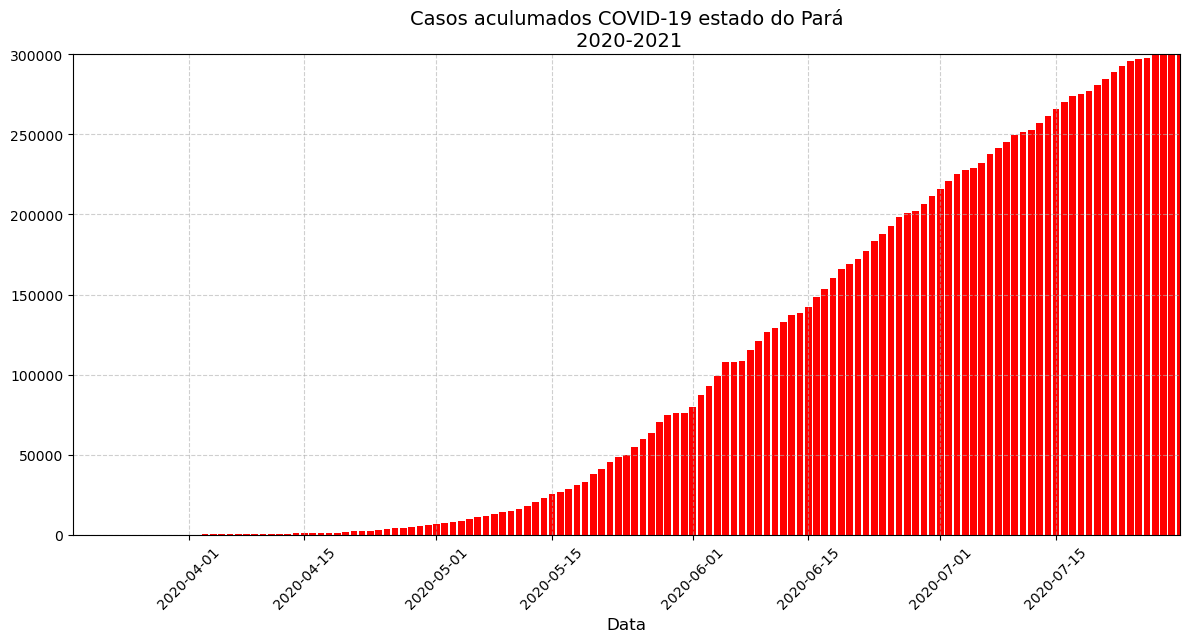

In [3]:
# Visualização
NCP=dfPA['new_confirmed'].values
NCB=dfbel['new_confirmed'].values

# casos acumulados
Cp=np.cumsum(NCP)
Cb=np.cumsum(NCB)

t_date=dfPA['date'].values

# periodo -01/02/2020 - 12/07/2020 (318)
yc=NCP[0:150]
y=Cp[0:150]
x=t_date[0:150] 

plt.figure(figsize=(12, 6))
plt.bar(x, y, color='red', label='Dados originais')
plt.title('Casos aculumados COVID-19 estado do Pará\n 2020-2021', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.tight_layout()
plt.ylim([0,300000])
plt.xlim(pd.to_datetime(['2020-03-18', '2020-07-30'])) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45);  # Rotaciona as datas para melhor legibilidade

## 🧮 Definição do Modelo SIRC


In [4]:
#funcoes
def solve_sirc(t,N,beta,gamma,I0):
    """Resolve o modelo SIRC e retorna casos acumulados."""
    R0 = 0
    C0 = I0
    S0 = N - I0 - R0
    y0 = [S0, I0, R0, C0]
    sol = odeint(model.SIRC, y0, t, args=(N, beta, gamma))
    return sol[:, 3]

print(datetime.now().isoformat(timespec='seconds'))

2025-05-31T17:50:30


## 🎯 Estimativa Inicial dos Parâmetros


In [9]:
c = y                  
t = np.arange(len(c))
#I0=1.728745
#N=700000
# gamma_i=0.291505
# beta_i=0.437257

R0 = 0
#C0 = I0             # Casos acumulados iniciais = infectados iniciais
#S0 = N  - I0 - R0
#y0 = [S0, I0, R0, C0]


# Estimar chutes inicias e N
K,r,A = model.initial_SIRC(c)

I0 = K / (A + 1)         #infectados inicias
N = 2 * K                #populacao
gamma_i = 2 * r          #taxa de recuperacao
beta_i = 1.5 * gamma_i   #taxa de contagio

# ---------------------------
# PARÂMETROS INICIAIS
# ---------------------------
print('\n' + '='*40)
print('PARÂMETROS INICIAIS'.center(40))
print('='*40)
print(f'{"I0:":<10}{I0:>30.6f}')
print(f'{"N:":<10}{N:>30.6f}')
print(f'{"gamma_i:":<10}{gamma_i:>30.6f}')
print(f'{"beta_i:":<10}{beta_i:>30.6f}')
print(datetime.now().isoformat(timespec='seconds'))
c


          PARÂMETROS INICIAIS           
I0:                             1.728745
N:                         708093.675215
gamma_i:                        0.291505
beta_i:                         0.437257
2025-05-31T17:52:25


array([     2,      2,      4,      4,      8,     10,     10,     14,
           26,     32,     36,     40,     52,     68,     82,     98,
          150,    164,    172,    246,    308,    330,    338,    434,
          474,    518,    620,    768,    974,   1114,   1254,   1282,
         1370,   1804,   2052,   2390,   2534,   3158,   3490,   4140,
         4438,   4638,   5172,   5998,   6718,   7454,   7840,   8524,
         9512,  11048,  11870,  13038,  14036,  14696,  16138,  18118,
        20688,  22958,  25264,  26928,  28402,  30934,  32644,  37858,
        41064,  45394,  48250,  49630,  54732,  59764,  63342,  70264,
        74592,  75718,  75922,  80028,  87304,  92946,  98946, 107720,
       107720, 108542, 115140, 121272, 126810, 129277, 132656, 136912,
       138448, 142486, 148384, 153246, 160144, 165762, 169308, 172040,
       177272, 183416, 188072, 192944, 198626, 200886, 202414, 206412,
       211706, 216134, 220822, 225062, 227622, 229070, 232304, 237488,
      

## ⚙️ Ajuste dos Parâmetros com lmfit

In [7]:
# Configurar modelo
SIRC_model= lmfit.Model(solve_sirc,independent_vars=['t'])


print(N,beta_i,gamma_i,I0)
# # Definição dos limites dos parametros
params = SIRC_model.make_params()
params['N'].set(value=N, vary=False)
params['beta'].set(value=beta_i, min=0.001, max=3.0)
params['gamma'].set(value=gamma_i, min=0.001, max=2.0)
params['I0'].set(value=I0, vary=False)
                # min=1, max=N)
result = SIRC_model.fit(y, params, t=t)
print(result.fit_report())

708093.6752149244 0.43725681453569565 0.2915045430237971 1.7287449368636383
[[Model]]
    Model(solve_sirc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 150
    # variables        = 2
    chi-square         = 7.0351e+10
    reduced chi-square = 4.7535e+08
    Akaike info crit   = 2998.91995
    Bayesian info crit = 3004.94122
    R-squared          = 0.96905196
[[Variables]]
    N:      708093.7 (fixed)
    beta:   0.51409090 +/- 0.00846905 (1.65%) (init = 0.4372568)
    gamma:  0.39552586 +/- 0.00806913 (2.04%) (init = 0.2915045)
    I0:     1.728745 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +0.9973


## 📉 Resultados dos ajustes

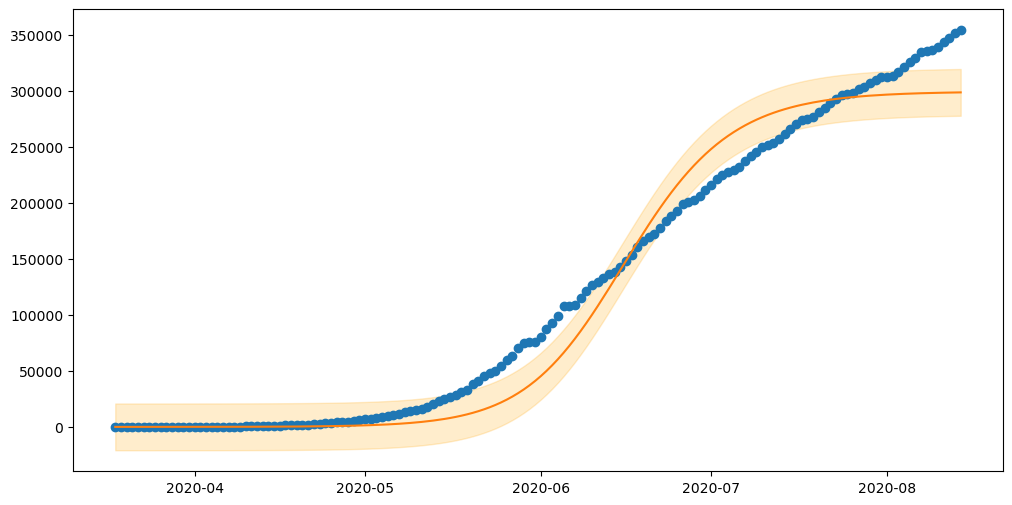

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x,y,'o',label='dados')
plt.plot(x,result.best_fit,label='melhor ajuste');  #melhor ajuste do modelo
plt.fill_between(
    x, 
    result.best_fit - result.residual.std(), 
    result.best_fit+ result.residual.std(), 
    color='Orange', alpha=0.2, label='Incerteza'
);